# Perform EDA on a DataFrame

In [224]:
!pip install wordcloud
!pip install nltk
!pip install empath
!pip install symspellpy
!pip install textacy
!pip install NRCLex

  Using cached matplotlib-3.6.1-cp39-cp39-win_amd64.whl (7.2 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\PythonFolder\\RedditScraper\\venv\\Lib\\site-packages\\matplotlib\\_c_internal_utils.cp39-win_amd64.pyd'
Check the permissions.


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached symspellpy-6.7.7-py3-none-any.whl (2.6 MB)
  Using cached editdistpy-0.1.3.tar.gz (57 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build editdistpy


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [5 lines of output]
  running bdist_wheel
  running build
  running build_ext
  building 'editdistpy.levenshtein' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for editdistpy
ERROR: Could not build wheels for editdistpy, which is required to install pyproject.toml-based projects

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [225]:
# from symspellpy import SymSpell
import pandas as pd
import json
import ast
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import sys, os
import numpy as np
import pickle
import nltk
from textblob import Word
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from string import digits
from collections import Counter
import re
import math
from nrclex import NRCLex
import textacy
from empath import Empath
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lawli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lawli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lawli\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lawli\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [226]:
# Tonkenizer. Lemmatizer is used here to achieve full morphological analysis and accurately identify the lemma for each word, this is better than simply stemming. 
WNL = nltk.WordNetLemmatizer()
lexicon = Empath()
# symsp = SymSpell()

In [227]:
# function to clean up texts by transforming to lower case, also removing apostrophe
def lowerRep(text):
    text = text.lower()
    text = text.replace("'", "")
    return text

# removing number
def removeNum(text):
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    return text

# remove extra chars and stop words
def removeChar(text):
    tokens = nltk.word_tokenize(text)
    text1 = nltk.Text(tokens)
    text_content = [''.join(re.split("[ .,;:!?‘’``''@#$%^_&*()<>{}~\n\t\\\-]", word)) for word in text1]
    return text_content

# remove URLs and images
def removeURL(text):
    
    if isinstance(text, str):
        text = re.sub(r'http\S+', '', text)
    else: 
        text = "" 
    return text

# remove ![img] string
def removeImg(text):
    text = re.sub(r'!\[img]\S+', '', text)
    return text

# initial removal of stopwords and empty spaces
def removeSpace(text, stopwords):
    text = [word for word in text if word not in stopwords]
    text = [s for s in text if len(s) != 0]
    return text

# lemmatize
def lemmatize(text):
    text = [WNL.lemmatize(t, 'v') for t in text]
    return text

# tokenize
def tokenize(text):
    tokens = [nltk.word_tokenize(i) for i in text]
    return tokens

def correct_spelling(sentence):
    terms = symsp.lookup_compound(sentence,
    max_edit_distance=2)
    return terms

def get_empath_scores(sentence, normalize = True):
      return lexicon.analyze(sentence, normalize = normalize)
    
def get_nrc(sentence):
    emotion = NRCLex(" ".join(sentence))
    freq = emotion.affect_frequencies
    if 'anticipation' not in freq:
        freq['anticipation'] = 0
    return freq

def get_pos_words(sentence, tag):
    text = nltk.word_tokenize(" ".join(sentence))
    pos_tagged = nltk.pos_tag(text)
    pos_tagged_words = [word[0] for word in pos_tagged if word[1].startswith(tag)]
    return pos_tagged_words

def get_sr_count(sentence):
    self_reference_words = ["i", "im", "me", "myself", "mine", "my", "self", "m"]
    sr_count = 0
    lst = [1 for word in sentence if word in self_reference_words]
    return sum(lst)


In [229]:
subreddit_name = "NevilleGoddard"
file_name = f"{subreddit_name}/{subreddit_name}_mentalhealth_common_author_posts"

df_subreddit = pd.read_csv(f"{file_name}.csv")

print(df_subreddit.shape)
df_subreddit.head()

(13943, 5)


,isodate,subreddit,author,body,source
0,2022-10-22 07:06:55,NevilleGoddard,DisastrousNight7229,Was looking for an outsider's perspective.,NevilleGoddard
1,2022-10-22 07:06:30,NevilleGoddard,DisastrousNight7229,Are you limiting contact with them? How do you...,NevilleGoddard
2,2022-10-22 05:13:46,Vindicta,DisastrousNight7229,It was a combination of things I believe. Main...,NevilleGoddard
3,2022-10-21 14:16:30,NevilleGoddard,DisastrousNight7229,Had no idea he talked about this. Thank you so...,NevilleGoddard
4,2022-10-21 13:45:52,Vindicta,DisastrousNight7229,This is most likely not what you mean by an un...,NevilleGoddard


In [230]:
posts_stopwords = ['hi', 'hello', 'everyone', 'thank', 'thankyou'] + list(STOPWORDS)

#pre-process to remove duplicate posters, any bots, and posts that have the word quote
# df_subreddit.reset_index(inplace = True)
df_subreddit = df_subreddit[df_subreddit['author']!="[deleted]"] 
df_subreddit = df_subreddit[df_subreddit['body']!="[deleted]"] 
df_subreddit = df_subreddit[df_subreddit['body']!="[removed]"]
df_subreddit["body"].dropna(how = 'all', inplace = True)
df_subreddit = df_subreddit.drop_duplicates()

df_subreddit['processed'] = df_subreddit["body"].apply(lambda x: removeURL(x))
df_subreddit['processed'] = df_subreddit["processed"].apply(lambda x: removeImg(x))
df_subreddit['processed'] = df_subreddit["processed"].apply(lambda x: lowerRep(x))
df_subreddit['processed'] = df_subreddit["processed"].apply(lambda x: removeNum(x))
df_subreddit['processed'] = df_subreddit["processed"].apply(lambda x: removeChar(x))
df_subreddit['processed'] = df_subreddit["processed"].apply(lambda x: removeSpace(x, posts_stopwords))
df_subreddit['processed'] = df_subreddit["processed"].apply(lambda x: lemmatize(x))
df_subreddit = df_subreddit[ df_subreddit["processed"].apply(lambda x: len(x) > 0) ]
df_subreddit["processed"].dropna(how = 'all', inplace = True)
df_subreddit.to_csv(f"{file_name}_preprocessed.csv", index = False)
print(df_subreddit.shape)
df_subreddit.head()

(11881, 6)


,isodate,subreddit,author,body,source,processed
0,2022-10-22 07:06:55,NevilleGoddard,DisastrousNight7229,Was looking for an outsider's perspective.,NevilleGoddard,"[look, outsiders, perspective]"
1,2022-10-22 07:06:30,NevilleGoddard,DisastrousNight7229,Are you limiting contact with them? How do you...,NevilleGoddard,"[limit, contact]"
2,2022-10-22 05:13:46,Vindicta,DisastrousNight7229,It was a combination of things I believe. Main...,NevilleGoddard,"[combination, things, believe, mainly, tretino..."
3,2022-10-21 14:16:30,NevilleGoddard,DisastrousNight7229,Had no idea he talked about this. Thank you so...,NevilleGoddard,"[idea, talk, much]"
4,2022-10-21 13:45:52,Vindicta,DisastrousNight7229,This is most likely not what you mean by an un...,NevilleGoddard,"[likely, mean, unfortunate, life, event, prett..."


In [231]:
df_subreddit = pd.read_csv(f"{file_name}_preprocessed.csv")
df_subreddit["processed"] = df_subreddit["processed"].apply(lambda x: ast.literal_eval(x))
df_subreddit.head()

,isodate,subreddit,author,body,source,processed
0,2022-10-22 07:06:55,NevilleGoddard,DisastrousNight7229,Was looking for an outsider's perspective.,NevilleGoddard,"[look, outsiders, perspective]"
1,2022-10-22 07:06:30,NevilleGoddard,DisastrousNight7229,Are you limiting contact with them? How do you...,NevilleGoddard,"[limit, contact]"
2,2022-10-22 05:13:46,Vindicta,DisastrousNight7229,It was a combination of things I believe. Main...,NevilleGoddard,"[combination, things, believe, mainly, tretino..."
3,2022-10-21 14:16:30,NevilleGoddard,DisastrousNight7229,Had no idea he talked about this. Thank you so...,NevilleGoddard,"[idea, talk, much]"
4,2022-10-21 13:45:52,Vindicta,DisastrousNight7229,This is most likely not what you mean by an un...,NevilleGoddard,"[likely, mean, unfortunate, life, event, prett..."


## N-Gram 

In [232]:
posts_content = list(df_subreddit['processed'])
posts_content = [word for processed in posts_content for word in processed]

stop_words = posts_stopwords + \
['dont', "don't", "want", "feel", "think","know", "make", "t", "ive", "doesn't", \
 "doesn t", "go", "will", "im", "say", "s", "m", "see", "don", "gon", "na"]

posts_content = [word for word in posts_content if word not in stop_words]

unigrams = [str(u[0]) for u in nltk.ngrams(posts_content, 1)]
bigrams = [" ".join(bi) for bi in nltk.ngrams(posts_content, 2)]

posts_dict_unigram = Counter(unigrams)
posts_dict_bigram = Counter(bigrams)

In [233]:
print("Most Frequent Unigrams:")
unigram_freq_df = pd.DataFrame(posts_dict_unigram.most_common(), columns = ["Unigram", "Frequency"])
unigram_freq_df.to_csv(f"{file_name}_unigram.csv", index = False)
unigram_freq_df = pd.read_csv(f"{file_name}_unigram.csv")
unigram_freq_df.head(20)

Most Frequent Unigrams:


,Unigram,Frequency
0,time,3258
1,people,2426
2,one,2405
3,now,2374
4,even,2341
5,try,2275
6,really,2268
7,work,2159
8,take,1988
9,love,1856


In [234]:
print("Most Frequent Bigrams:")
bigram_freq_df = pd.DataFrame(posts_dict_bigram.most_common(), columns = ["Bigram", "Frequency"])
bigram_freq_df.to_csv(f"{file_name}_bigram.csv", index = False)
bigram_freq_df = pd.read_csv(f"{file_name}_bigram.csv")
bigram_freq_df.head(20)

Most Frequent Bigrams:


,Bigram,Frequency
0,| |,1231
1,right now,339
2,amp xb,289
3,come back,201
4,even though,191
5,years ago,183
6,first time,155
7,every time,149
8,mental health,132
9,” “,132


## Wordclouds

Text(0.5, 1.0, 'Unigram Wordcloud')

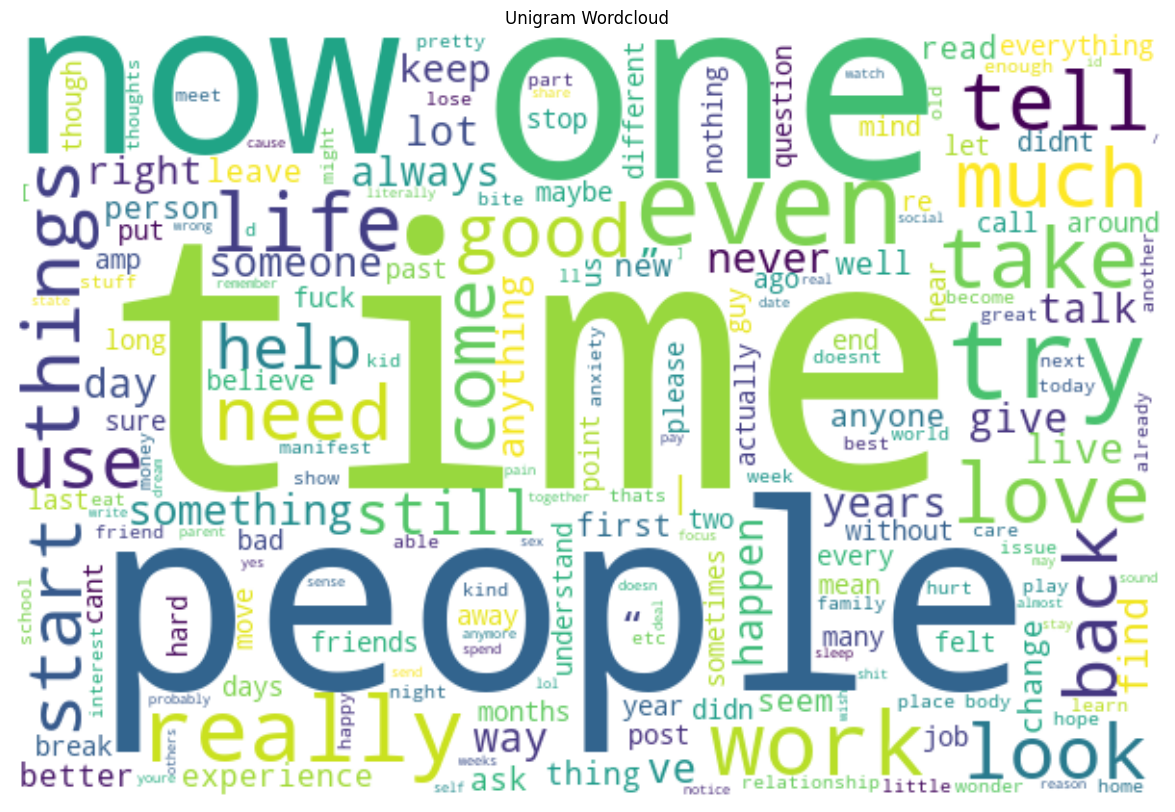

In [235]:
wc_posts = WordCloud(
        background_color = 'white',
        stopwords = posts_stopwords, 
        height = 400, 
        width = 600)
wc_posts.generate_from_frequencies(dict(zip(unigram_freq_df.Unigram, unigram_freq_df.Frequency)))

fig = plt.figure(figsize=(20, 10))
plt.imshow(wc_posts, interpolation="bilinear")
plt.axis('off')
plt.title('Unigram Wordcloud', loc='center')

Text(0.5, 1.0, 'Bigram Wordcloud')

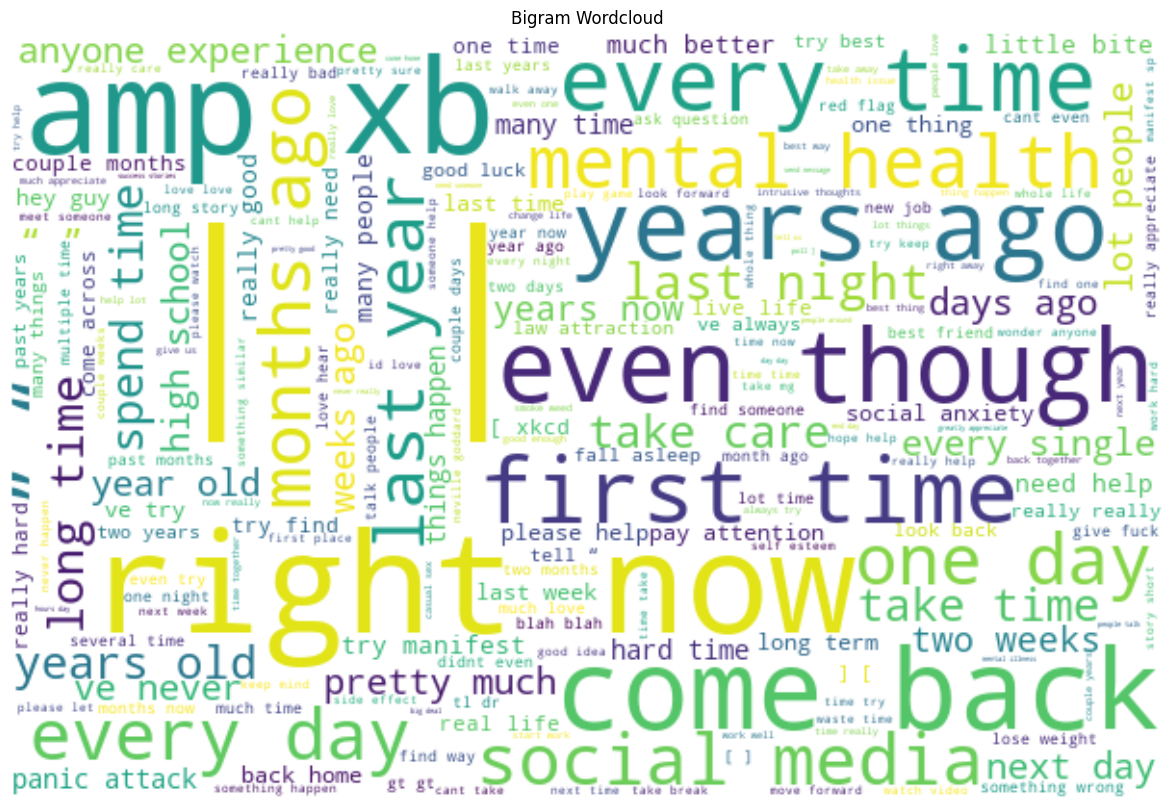

In [236]:
wc_posts = WordCloud(
        background_color = 'white',
        stopwords = posts_stopwords, 
        height = 400, 
        width = 600)
wc_posts.generate_from_frequencies(dict(zip(bigram_freq_df.Bigram, bigram_freq_df.Frequency)))

fig = plt.figure(figsize=(20, 10))
plt.imshow(wc_posts, interpolation="bilinear")
plt.axis('off')
plt.title('Bigram Wordcloud', loc='center')

## LDA Topics

In [237]:
#tbd

## Polarity and Subjectivity scores

In [238]:
df_subreddit['Polarity'] = df_subreddit['processed'].apply(lambda post: TextBlob(str(post)).sentiment[0])
df_subreddit['Subjectivity'] = df_subreddit['processed'].apply(lambda post: TextBlob(str(post)).sentiment[1])
df_subreddit.head()

,isodate,subreddit,author,body,source,processed,Polarity,Subjectivity
0,2022-10-22 07:06:55,NevilleGoddard,DisastrousNight7229,Was looking for an outsider's perspective.,NevilleGoddard,"[look, outsiders, perspective]",0.000000,0.000000
1,2022-10-22 07:06:30,NevilleGoddard,DisastrousNight7229,Are you limiting contact with them? How do you...,NevilleGoddard,"[limit, contact]",0.000000,0.000000
2,2022-10-22 05:13:46,Vindicta,DisastrousNight7229,It was a combination of things I believe. Main...,NevilleGoddard,"[combination, things, believe, mainly, tretino...",-0.016667,0.241667
3,2022-10-21 14:16:30,NevilleGoddard,DisastrousNight7229,Had no idea he talked about this. Thank you so...,NevilleGoddard,"[idea, talk, much]",0.200000,0.200000
4,2022-10-21 13:45:52,Vindicta,DisastrousNight7229,This is most likely not what you mean by an un...,NevilleGoddard,"[likely, mean, unfortunate, life, event, prett...",0.065000,0.574833


In [239]:
df_subreddit[["Polarity", "Subjectivity"]].to_csv(f"{file_name}_subpol.csv", index = False)
pol_sub_df = pd.read_csv(f"{file_name}_subpol.csv")

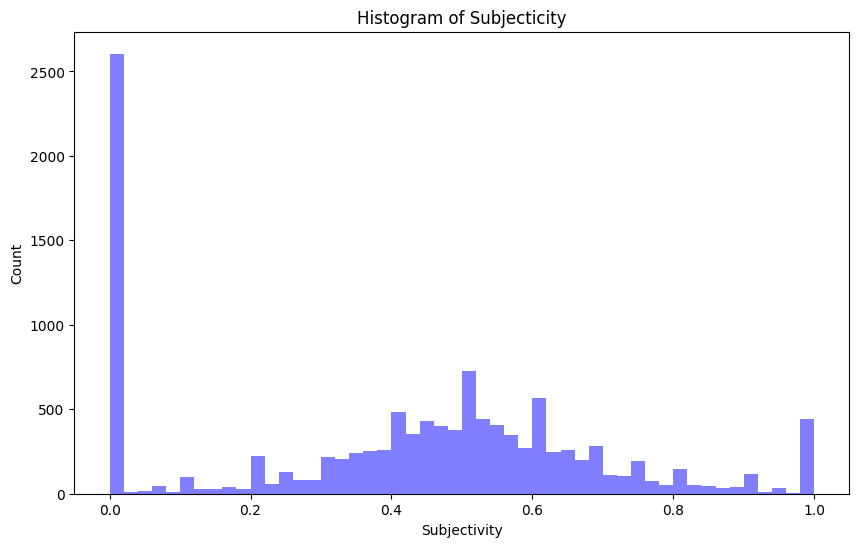

In [240]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(pol_sub_df.Subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Subjecticity')
plt.show();

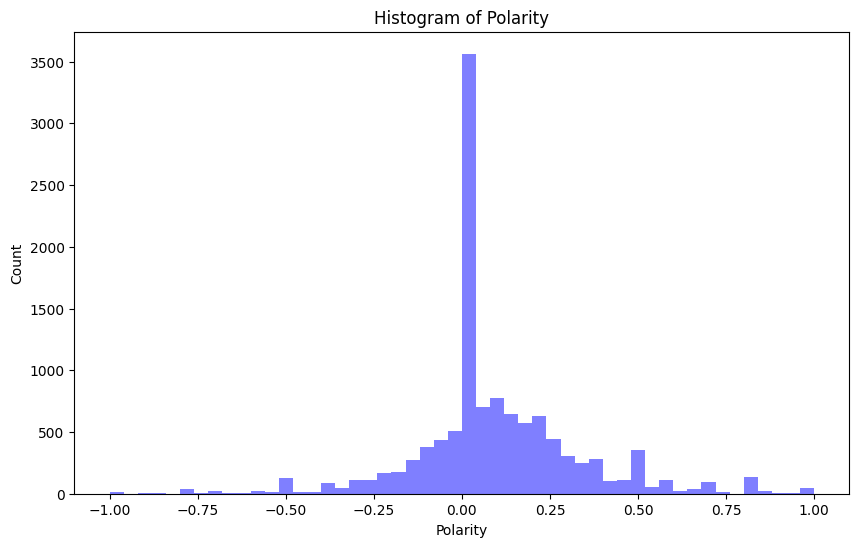

In [241]:
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(pol_sub_df.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show();

## Empath scores

In [242]:
rows = df_subreddit['processed'].apply(lambda x: get_empath_scores(x, True))
rows = rows.tolist()
empath_scores = pd.DataFrame.from_dict(rows)
empath_scores.columns = [f"emp_{col}" for col in empath_scores.columns]
df_subreddit.reset_index(inplace = True)
df_subreddit = pd.concat([df_subreddit, empath_scores], axis=1)

print(df_subreddit.shape)
df_subreddit.head()

(11881, 203)


,index,isodate,subreddit,author,body,source,processed,Polarity,Subjectivity,emp_help,...,emp_weapon,emp_children,emp_monster,emp_ocean,emp_giving,emp_contentment,emp_writing,emp_rural,emp_positive_emotion,emp_musical
0,0,2022-10-22 07:06:55,NevilleGoddard,DisastrousNight7229,Was looking for an outsider's perspective.,NevilleGoddard,"[look, outsiders, perspective]",0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1,2022-10-22 07:06:30,NevilleGoddard,DisastrousNight7229,Are you limiting contact with them? How do you...,NevilleGoddard,"[limit, contact]",0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2,2022-10-22 05:13:46,Vindicta,DisastrousNight7229,It was a combination of things I believe. Main...,NevilleGoddard,"[combination, things, believe, mainly, tretino...",-0.016667,0.241667,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,3,2022-10-21 14:16:30,NevilleGoddard,DisastrousNight7229,Had no idea he talked about this. Thank you so...,NevilleGoddard,"[idea, talk, much]",0.200000,0.200000,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,4,2022-10-21 13:45:52,Vindicta,DisastrousNight7229,This is most likely not what you mean by an un...,NevilleGoddard,"[likely, mean, unfortunate, life, event, prett...",0.065000,0.574833,0.009174,...,0.0,0.018349,0.0,0.0,0.009174,0.018349,0.0,0.0,0.0,0.0


In [243]:
"""
Top 10 Empath categories based on average normalized values
"""
mean_df = empath_scores.mean(axis=0).sort_values(ascending = False)[:10]
mean_df = mean_df.reset_index()
mean_df.to_csv(f"{file_name}_empath_top10.csv", index = False)
mean_df

,index,0
0,emp_speaking,0.028690
1,emp_communication,0.026955
2,emp_positive_emotion,0.021911
3,emp_negative_emotion,0.021430
4,emp_love,0.019424
5,emp_giving,0.018423
6,emp_friends,0.017999
7,emp_optimism,0.017120
8,emp_violence,0.016180
9,emp_pain,0.015593


In [244]:
mean_df = pd.read_csv(f"{file_name}_empath_top10.csv").set_index('index')
print("Top 10 most important Emapth categories")

Top 10 most important Emapth categories


<Figure size 5000x2000 with 0 Axes>

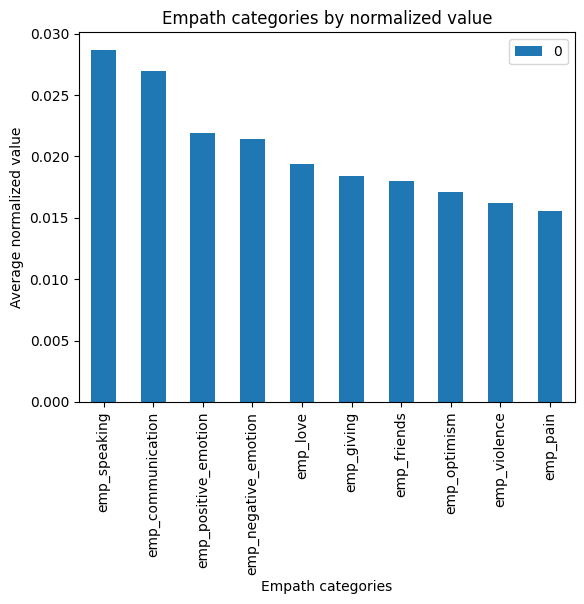

In [245]:
plt.figure(figsize=(50,20))
plt.rcParams.update({'font.size': 10})
mean_df.plot(kind = 'bar')
plt.xlabel('Empath categories')
plt.ylabel('Average normalized value')
plt.title('Empath categories by normalized value')
plt.xticks(rotation=90)
plt.show()

## NRCLex scores

In [246]:
nrc_emotions = df_subreddit['processed'].apply(lambda x: get_nrc(x))
nrc_emotions = nrc_emotions.tolist()
nrc_emotions = pd.DataFrame.from_dict(nrc_emotions)
nrc_emotions.columns = [f"nrc_{em}" for em in nrc_emotions.columns]

df_subreddit = pd.concat([df_subreddit, nrc_emotions], axis=1)

df_subreddit.reset_index()
print(df_subreddit.shape)

df_subreddit.head(50)

(11881, 214)


,index,isodate,subreddit,author,body,source,processed,Polarity,Subjectivity,emp_help,...,nrc_anger,nrc_anticip,nrc_trust,nrc_surprise,nrc_positive,nrc_negative,nrc_sadness,nrc_disgust,nrc_joy,nrc_anticipation
0,0,2022-10-22 07:06:55,NevilleGoddard,DisastrousNight7229,Was looking for an outsider's perspective.,NevilleGoddard,"[look, outsiders, perspective]",0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2022-10-22 07:06:30,NevilleGoddard,DisastrousNight7229,Are you limiting contact with them? How do you...,NevilleGoddard,"[limit, contact]",0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,2022-10-22 05:13:46,Vindicta,DisastrousNight7229,It was a combination of things I believe. Main...,NevilleGoddard,"[combination, things, believe, mainly, tretino...",-0.016667,0.241667,0.000000,...,0.000000,0.0,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.000000,0.000000
3,3,2022-10-21 14:16:30,NevilleGoddard,DisastrousNight7229,Had no idea he talked about this. Thank you so...,NevilleGoddard,"[idea, talk, much]",0.200000,0.200000,0.000000,...,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,2022-10-21 13:45:52,Vindicta,DisastrousNight7229,This is most likely not what you mean by an un...,NevilleGoddard,"[likely, mean, unfortunate, life, event, prett...",0.065000,0.574833,0.009174,...,0.089744,0.0,0.076923,0.051282,0.166667,0.128205,0.076923,0.038462,0.089744,0.179487
5,5,2022-10-20 07:29:55,PMDD,DisastrousNight7229,"50mg is the lowest therapeutical dose, so half...",NevilleGoddard,"[mg, lowest, therapeutical, dose, half, unlike...",0.046296,0.448148,0.000000,...,0.000000,0.0,0.142857,0.095238,0.238095,0.095238,0.047619,0.000000,0.142857,0.238095
6,6,2022-10-20 05:33:05,PMDD,DisastrousNight7229,May I ask you what dose you are on? It's likel...,NevilleGoddard,"[may, ask, dose, likely, benefit, higher, dose...",0.125000,0.750000,0.125000,...,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,2022-10-18 09:59:39,PMDD,DisastrousNight7229,"Thank you so much, this is exactly the explana...",NevilleGoddard,"[much, exactly, explanation, hop]",0.250000,0.250000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8,2022-10-17 11:49:35,h3h3productions,DisastrousNight7229,This looks more like Tate than Dan,NevilleGoddard,"[look, tate, dan]",0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,9,2022-10-17 02:23:53,zoloft,DisastrousNight7229,What dose were you on?,NevilleGoddard,[dose],0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [247]:
"""
NRCLex Emotions distribution
"""
sum_df = nrc_emotions.sum(axis=0)
sum_df = sum_df.reset_index()
sum_df.to_csv(f"{file_name}_nrclex.csv", index = False)
print("NRCLex Emotions Distribution")
print(sum_df)

NRCLex Emotions Distribution
               index            0
0           nrc_fear   724.354801
1          nrc_anger   502.537313
2        nrc_anticip     0.000000
3          nrc_trust  1293.153741
4       nrc_surprise   494.340837
5       nrc_positive  2364.023091
6       nrc_negative  1391.801707
7        nrc_sadness   611.408115
8        nrc_disgust   393.884432
9            nrc_joy   826.861016
10  nrc_anticipation  1191.634947


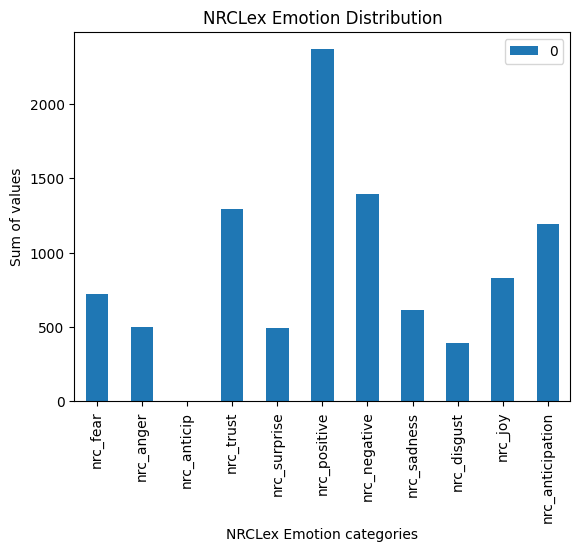

In [248]:
sum_df = pd.read_csv(f"{file_name}_nrclex.csv").set_index('index')
sum_df.plot(kind = 'bar')
plt.xlabel('NRCLex Emotion categories')
plt.ylabel('Sum of values')
plt.title('NRCLex Emotion Distribution')
plt.rcParams.update({'font.size': 5})
plt.show()

## Verb Category Frequency

In [249]:
verb_list = df_subreddit['processed'].apply(lambda x: get_pos_words(x, "VB"))
list_of_verbs = [word for lst in verb_list for word in lst]

list_synsets = []
for word in list_of_verbs:
    for synset in wn.synsets(word):
        list_synsets.append(synset.lexname())
        
list_synsets = [word[5:] for word in list_synsets if word.startswith("verb")]
verb_count = Counter(list_synsets)

verb_df = pd.DataFrame.from_dict(verb_count, orient = 'index').reset_index()
verb_df.columns = ["Verb Category", "Count"]
verb_df.to_csv(f"{file_name}_verb_freq.csv", index = False)

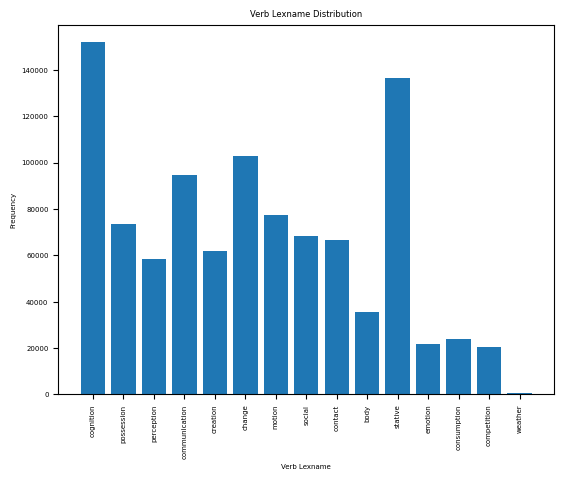

In [250]:
verb_df = pd.read_csv(f"{file_name}_verb_freq.csv")

plt.bar(verb_df["Verb Category"], verb_df['Count'])
plt.xlabel('Verb Lexname')
plt.ylabel('Frequency')
plt.title('Verb Lexname Distribution')
plt.rcParams.update({'font.size': 10})
plt.xticks(rotation=90)
plt.show()

## Noun Category Frequency

In [251]:
noun_list = df_subreddit['processed'].apply(lambda x: get_pos_words(x, "NN"))
list_of_nouns = [word for lst in noun_list for word in lst]

list_synsets = []
for word in list_of_nouns:
    for synset in wn.synsets(word):
        list_synsets.append(synset.lexname())
        
list_synsets = [word[5:] for word in list_synsets if word.startswith("noun")]
noun_count = Counter(list_synsets)

noun_df = pd.DataFrame.from_dict(noun_count, orient = 'index').reset_index()
noun_df.columns = ["Noun Category", "Count"]
noun_df.to_csv(f"{file_name}_noun_freq.csv", index = False)

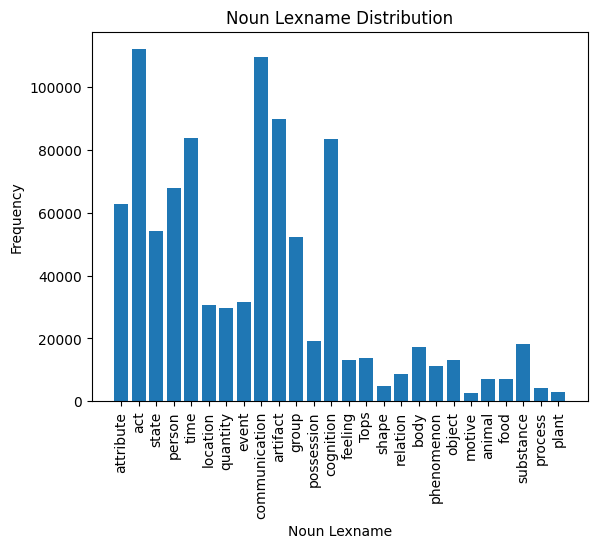

In [252]:
noun_df = pd.read_csv(f"{file_name}_noun_freq.csv")

plt.bar(noun_df["Noun Category"], noun_df['Count'])

# plt.bar(noun_count.keys(), noun_count.values())
plt.xlabel('Noun Lexname')
plt.ylabel('Frequency')
plt.title('Noun Lexname Distribution')
plt.rcParams.update({'font.size': 10})
plt.xticks(rotation=90)
plt.show()

## Self-Focused Attention

In [253]:
sr_count = sum(df_subreddit["body"].apply(lambda x: get_sr_count(x)))
total_word_count = sum(df_subreddit["body"].apply(lambda x: len(x)))

print(f"Self Reference word count : {sr_count}")
print(f"Total word count : {total_word_count}")
print(f"Percentage of SFA : {sr_count/total_word_count : .2%}")

Self Reference word count : 380857
Total word count : 5142399
Percentage of SFA :  7.41%


In [254]:
metrics ={
    "Self Reference word count" : sr_count,
    "Total word count" : total_word_count,
    "Percentage of SFA" : sr_count/total_word_count
}
    
with open(f"{file_name}_metrics.json", "w") as outfile:
    json.dump(metrics, outfile)

In [255]:
with open(f"{file_name}_metrics.json", "r") as infile:
    out = json.load(infile)

## Save processed file

In [256]:
df_subreddit.to_csv(f'{file_name}_processed.csv', index= False)